# <font color="red">Projet de classe - AS3 - 2024/2025</font>

## <font color="red">Ce projet est réalisé dans le cadre du cours de Natural Language Processing! </font>

Le Sujet 1 proposé consiste à étudier l’effet de la tokenization sur la performance d’un modèle de classification de texte. 

## <font color="red">Objectif </font>

Évaluer comment différentes méthodes de tokenization influencent la performance d’un modèle de classification de texte, en termes de précision, rappel, F1-score, ou d'autres métriques pertinentes

## <font color="red">Equipe projet : </font>
##### <font color="lightblue">Klaus Wilfried KUEKOU</font>
#### <font color="lightblue">Youssouf S.  GADO</font>
##### <font color="lightblue">Phil Arthur DJOUKENG.</font>


<font color="green">La tokenization est une étape fondamentale du traitement automatique du langage naturel (NLP). Elle consiste à segmenter un texte brut en unités significatives, appelées "tokens", afin de faciliter son analyse et son traitement par des modèles de machine learning. Ce projet vise à explorer l'impact de différentes méthodes de tokenization (mot par mot, sous-mots, caractères, phrases, espaces) sur la performance d'un modèle de classification de texte. L'objectif est de comparer ces techniques en termes de précision, rappel, et F1-score, en utilisant un jeu de données contenant des avis et leurs niveaux de satisfaction. Cette étude permettra de mieux comprendre comment le choix d'une méthode de tokenization influence les résultats et les performances des modèles NLP.</font>

# <font color = 'blue'>Importation des libraries necessaires</font>

In [1]:
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt


# Assurez-vous d'avoir téléchargé les ressources nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Définir les stop words pour l'anglais
stop_words = set(stopwords.words('english'))

# <font color = 'blue'>Chargement du Dataset : Amazon Fine Food Reviews</font>

In [4]:
# Gestion des données
class DataHandler:
    def __init__(self, data_path):
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Le fichier {data_path} est introuvable. Veuillez le télécharger.")
        self.data_path = data_path

    def load_data(self):
        data = pd.read_csv(self.data_path, encoding='utf-8', delimiter=";", on_bad_lines='skip') # or on_bad_lines='warn'
        data = data[['Text', 'Score']]  # Conserver les colonnes pertinentes
        data = data.rename(columns={'Text': 'text', 'Score': 'label'})
        data['label'] = data['label'].apply(self.map_score_to_category)
        return data

    @staticmethod
    def map_score_to_category(score):
        if score <= 2:
            return 0  # Insatisfait
        elif score == 3:
            return 1  # Neutre
        else:
            return 2  # Satisfait

# Charger les données avec DataHandler
data_path = "Reviews_C.csv"
data_handler = DataHandler(data_path)
data = data_handler.load_data()

In [5]:
data.head(10)

,text,label
0,I have bought several of the Vitality canned d...,2
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,2
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,2
5,I got a wild hair for taffy and ordered this f...,2
6,This saltwater taffy had great flavors and was...,2
7,This taffy is so good. It is very soft and ch...,2
8,Right now I'm mostly just sprouting this so my...,2
9,This is a very healthy dog food. Good for thei...,2


<Axes: xlabel='label'>

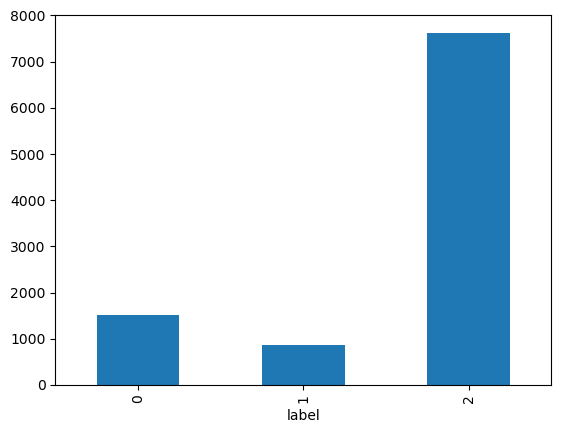

In [6]:
data['label'].value_counts().sort_index().plot(kind = 'bar')

# <font color = 'blue'>Diviser les données en données d'entraînement et données de test</font>

In [8]:
# Diviser les données
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'].astype(str), data['label'], test_size=0.2, random_state=42
) # les données d'entraînement représente 80% de la base et les données de test 20%.

# <font color = 'blue'>Modèle de classification simple de PyTorch</font>

In [10]:
# Modèle PyTorch simple
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

# <font color = 'blue'>Fonctions de Tokenization</font>

In [12]:
# Fonction de tokenization

def tokenize_words(texts):
    return [[word for word in nltk.word_tokenize(text) if word.lower() not in stop_words] for text in texts]

def tokenize_subwords(texts, tokenizer):
    return [[subword for subword in tokenizer.tokenize(text) if subword.lower() not in stop_words] for text in texts]

def tokenize_characters(texts):
    # Tokenize into characters but keep words together, only removing stop words as whole words
    return [" ".join([word for word in nltk.word_tokenize(text) if word.lower() not in nltk.corpus.stopwords.words('english')]) for text in texts]

def tokenize_sentences(texts):
    return [[sentence for sentence in nltk.sent_tokenize(text) if all(word.lower() not in stop_words for word in nltk.word_tokenize(sentence))] for text in texts]

def tokenize_spaces(texts):
    return [[word for word in text.split() if word.lower() not in stop_words] for text in texts]


# <font color = 'blue'>Fonction de Classification avec les types de tokenisation</font>

In [14]:

def classify_with_pytorch(train_texts, test_texts, train_labels, test_labels, tokenize_func, vectorizer=None):
    # Tokenization
    if tokenize_func == tokenize_characters:
        train_tokens = tokenize_func(train_texts)
        test_tokens = tokenize_func(test_texts)
    else:
        train_tokens = [" ".join(tokens) for tokens in tokenize_func(train_texts)]
        test_tokens = [" ".join(tokens) for tokens in tokenize_func(test_texts)]

    # Vérifier si les tokens sont vides
    if not any(train_tokens):
        raise ValueError("Train tokens are empty after preprocessing. Check your tokenization function and data.")
    if not any(test_tokens):
        raise ValueError("Test tokens are empty after preprocessing. Check your tokenization function and data.")

    # Vectorisation
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=1, max_df=0.95, stop_words=None)
        train_features = vectorizer.fit_transform(train_tokens)
        test_features = vectorizer.transform(test_tokens)
    else:
        train_features = vectorizer.fit_transform(train_tokens)
        test_features = vectorizer.transform(test_tokens)

    # Conversion en Tensors PyTorch
    train_features = torch.tensor(train_features.toarray(), dtype=torch.float32)
    test_features = torch.tensor(test_features.toarray(), dtype=torch.float32)
    train_labels = torch.tensor(train_labels.values, dtype=torch.long)
    test_labels = torch.tensor(test_labels.values, dtype=torch.long)

    # Chargement des données dans des DataLoader
    train_data = TensorDataset(train_features, train_labels)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    # Définir les dimensions
    input_dim = train_features.shape[1]
    hidden_dim = 100
    output_dim = len(train_labels.unique())

    # Initialisation du modèle, de la perte et de l'optimiseur
    model = TextClassifier(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraînement du modèle
    epochs = 10
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

    # Évaluation
    model.eval()
    with torch.no_grad():
        predictions = model(test_features).argmax(dim=1)
        accuracy = accuracy_score(test_labels, predictions)
        precision = precision_score(test_labels, predictions, average='weighted')
        recall = recall_score(test_labels, predictions, average='weighted')
        f1 = f1_score(test_labels, predictions, average='weighted')
        conf_matrix = confusion_matrix(test_labels, predictions)  # Matrice de confusion

    # Retourner les résultats
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "conf_matrix": conf_matrix  # Ajout de la matrice de confusion
    }, train_tokens, test_tokens, vectorizer

# <font color = 'blue'>Résultat pour chaque méthode de tokenization</font>

In [16]:
# Fonction pour afficher une matrice de confusion
def plot_confusion_matrix(conf_matrix, method_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Insatisfait", "Neutre", "Satisfait"],
                yticklabels=["Insatisfait", "Neutre", "Satisfait"])
    plt.title(f"Matrice de confusion - {method_name}")
    plt.ylabel("Vérité terrain")
    plt.xlabel("Prédictions")
    plt.show()

In [17]:
# Test des méthodes de tokenization
methods = {
    "Caractères": tokenize_characters,
    "Mot par mot": tokenize_words,
    "Sous-mots (BERT)": lambda texts: tokenize_subwords(texts, AutoTokenizer.from_pretrained("bert-base-uncased")),
    "Phrases": tokenize_sentences,
    "Espaces": tokenize_spaces,
}


--- Méthode : Caractères ---
Epoch 1, Loss: 204.5980
Epoch 2, Loss: 184.4048
Epoch 3, Loss: 170.8897
Epoch 4, Loss: 163.7001
Epoch 5, Loss: 155.3610
Epoch 6, Loss: 150.4449
Epoch 7, Loss: 147.9032
Epoch 8, Loss: 146.5049
Epoch 9, Loss: 145.7027
Epoch 10, Loss: 145.2567
Rapport de classification : {'accuracy': 0.8125, 'precision': 0.801554219574418, 'recall': 0.8125, 'f1_score': 0.8060676514507285, 'conf_matrix': array([[ 166,   38,  101],
       [  26,   54,   87],
       [  70,   53, 1405]], dtype=int64)}
Exemples de tokens (train) : ['smooth . normally drink dark roasts purchased lightning deal ( maybe friday sale ) . like .', "5 star hotel served tea meeting . fantastic . asked server could get name company , unable . Thank goodness Amazon able find . 's best many years . arrived time securely packed ."]
Exemples de tokens (test) : ["panicked could n't find Extra Key Lime pie gum stores . thought ... get everything ? Amazon course ! delight , gum ! love key lime pie like , next bes

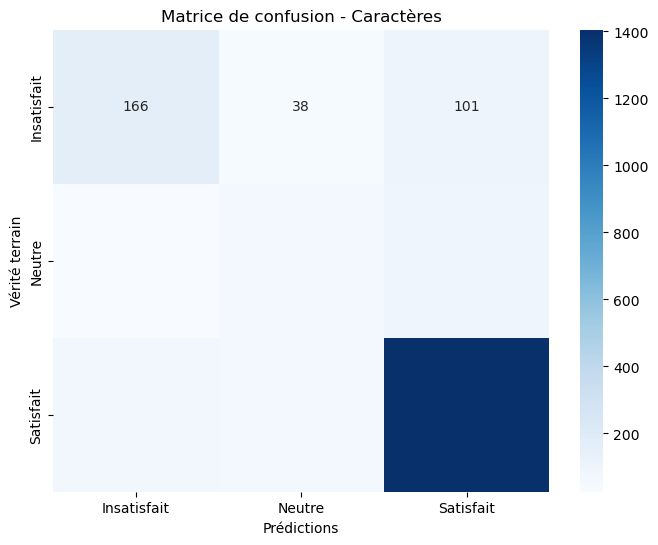


--- Méthode : Mot par mot ---
Epoch 1, Loss: 204.3687
Epoch 2, Loss: 182.3927
Epoch 3, Loss: 169.2251
Epoch 4, Loss: 162.2887
Epoch 5, Loss: 153.8897
Epoch 6, Loss: 149.1461
Epoch 7, Loss: 146.9300
Epoch 8, Loss: 145.8578
Epoch 9, Loss: 145.2662
Epoch 10, Loss: 144.8417
Rapport de classification : {'accuracy': 0.811, 'precision': 0.8002792763627835, 'recall': 0.811, 'f1_score': 0.8039557913228561, 'conf_matrix': array([[ 157,   45,  103],
       [  22,   54,   91],
       [  62,   55, 1411]], dtype=int64)}
Exemples de tokens (train) : ['smooth . normally drink dark roasts purchased lightning deal ( maybe friday sale ) . like .', "5 star hotel served tea meeting . fantastic . asked server could get name company , unable . Thank goodness Amazon able find . 's best many years . arrived time securely packed ."]
Exemples de tokens (test) : ["panicked could n't find Extra Key Lime pie gum stores . thought ... get everything ? Amazon course ! delight , gum ! love key lime pie like , next bes

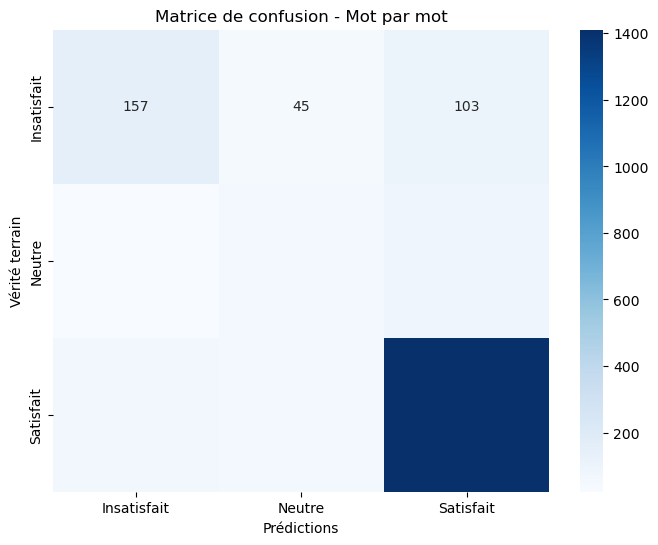


--- Méthode : Sous-mots (BERT) ---


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


Epoch 1, Loss: 205.6540
Epoch 2, Loss: 187.1359
Epoch 3, Loss: 173.1952
Epoch 4, Loss: 166.5286
Epoch 5, Loss: 158.5820
Epoch 6, Loss: 153.7715
Epoch 7, Loss: 151.2829
Epoch 8, Loss: 149.4173
Epoch 9, Loss: 148.5837
Epoch 10, Loss: 147.7052
Rapport de classification : {'accuracy': 0.8145, 'precision': 0.795580017691523, 'recall': 0.8145, 'f1_score': 0.801545925548287, 'conf_matrix': array([[ 145,   41,  119],
       [  30,   46,   91],
       [  48,   42, 1438]], dtype=int64)}
Exemples de tokens (train) : ['smooth . normally drink dark roast ##s purchased lightning deal ( maybe friday sale ) . like .', "5 star hotel served tea meeting . fantastic . asked server could get name company , unable . thank goodness amazon able find . ' best many years . arrived time securely packed ."]
Exemples de tokens (test) : ["panicked ' find extra key lime pie gum stores . thought . . . get everything ? amazon course ! delight , gum ! love key lime pie like , next best thing sinking teeth creamy , rich

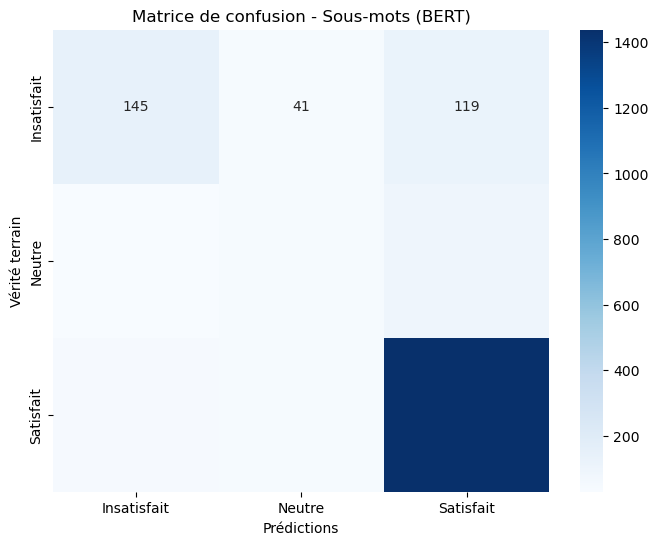


--- Méthode : Phrases ---
Epoch 1, Loss: 221.4990
Epoch 2, Loss: 197.6505
Epoch 3, Loss: 197.2858
Epoch 4, Loss: 196.8438
Epoch 5, Loss: 195.9387
Epoch 6, Loss: 194.9434
Epoch 7, Loss: 194.2623
Epoch 8, Loss: 193.7515
Epoch 9, Loss: 193.3963
Epoch 10, Loss: 193.1887
Rapport de classification : {'accuracy': 0.767, 'precision': 0.7540048758865247, 'recall': 0.767, 'f1_score': 0.6768012755092319, 'conf_matrix': array([[  13,    0,  292],
       [   2,    2,  163],
       [   9,    0, 1519]], dtype=int64)}
Exemples de tokens (train) : ['smooth.', '']
Exemples de tokens (test) : ['!', '!']
Nombre de caractéristiques vectorisées : 955


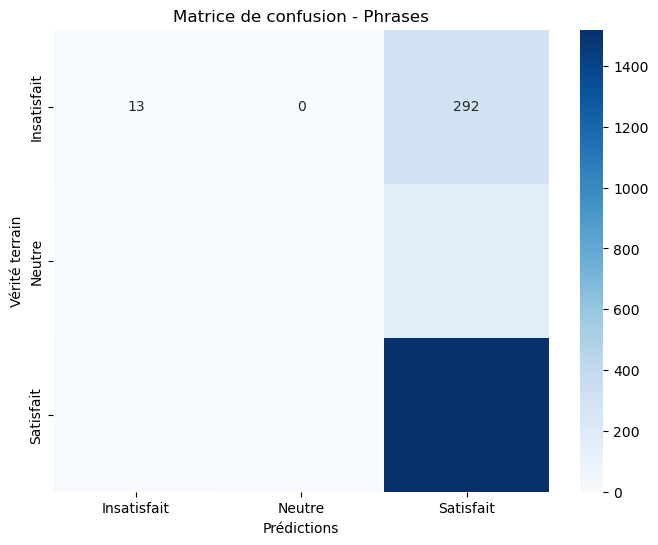


--- Méthode : Espaces ---
Epoch 1, Loss: 203.2638
Epoch 2, Loss: 183.4770
Epoch 3, Loss: 169.9242
Epoch 4, Loss: 161.1918
Epoch 5, Loss: 153.7533
Epoch 6, Loss: 149.9108
Epoch 7, Loss: 147.7728
Epoch 8, Loss: 146.4359
Epoch 9, Loss: 145.8856
Epoch 10, Loss: 145.4109
Rapport de classification : {'accuracy': 0.8105, 'precision': 0.8038909557088401, 'recall': 0.8105, 'f1_score': 0.8066032308806813, 'conf_matrix': array([[ 171,   37,   97],
       [  28,   56,   83],
       [  67,   67, 1394]], dtype=int64)}
Exemples de tokens (train) : ['smooth. normally drink dark roasts purchased lightning deal (or maybe friday sale). like it.', '5 star hotel served tea meeting. fantastic. asked server could get name company, unable. Thank goodness Amazon able find it. best many years. arrived time securely packed.']
Exemples de tokens (test) : ['panicked find Extra Key Lime pie gum stores. thought... get everything? Amazon course! delight, gum there! love key lime pie like do, next best thing sinking 

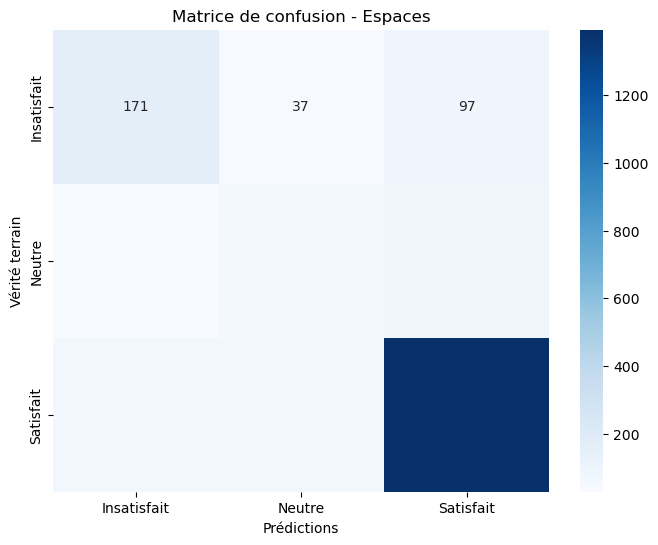

In [29]:
results = {}
# Appliquer chaque méthode de tokenization et afficher les résultats
for method, tokenize_func in methods.items():
    print(f"\n--- Méthode : {method} ---")
    report, train_tokens, test_tokens, vectorizer = classify_with_pytorch(
        train_texts, test_texts, train_labels, test_labels, tokenize_func
    )
    print("Rapport de classification :", report)
        # Afficher des exemples de tokenization et vectorisation
    print("Exemples de tokens (train) :", train_tokens[:2])
    print("Exemples de tokens (test) :", test_tokens[:2])
    print("Nombre de caractéristiques vectorisées :", len(vectorizer.get_feature_names_out()))

    results[method] = report
    
    plot_confusion_matrix(report['conf_matrix'], method)

# <font color = "blue">Sauvegarde des résultats dans le fichier resultat.txt</font>

In [33]:
with open("Results1.txt", "w") as f:
    for method, result in results.items():
        # Vérifier si result est un tuple de 4 éléments
        if isinstance(result, tuple) and len(result) == 4:
            metrics, train_tokens, test_tokens, vectorizer = result  # Déballer le tuple
        else:
            print(f"'=======Tokenization par {method}'=======: {result}")
            continue  # Passer à la méthode suivante
        
        f.write(f"\n--- Méthode : {method} ---\n")
        
        # Écrire les métriques numériques
        for metric, value in metrics.items():
            if metric != "conf_matrix":  # Ignorer la matrice de confusion
                f.write(f"{metric}: {value:.4f}\n")
        
        # Écrire la matrice de confusion séparément
        f.write("Matrice de confusion :\n")
        f.write(str(metrics["conf_matrix"]) + "\n")  # Convertir en chaîne de caractères 

'=======Tokenization par Caractères'=======: {'accuracy': 0.8125, 'precision': 0.801554219574418, 'recall': 0.8125, 'f1_score': 0.8060676514507285, 'conf_matrix': array([[ 166,   38,  101],
       [  26,   54,   87],
       [  70,   53, 1405]], dtype=int64)}
'=======Tokenization par Mot par mot'=======: {'accuracy': 0.811, 'precision': 0.8002792763627835, 'recall': 0.811, 'f1_score': 0.8039557913228561, 'conf_matrix': array([[ 157,   45,  103],
       [  22,   54,   91],
       [  62,   55, 1411]], dtype=int64)}
'=======Tokenization par Sous-mots (BERT)'=======: {'accuracy': 0.8145, 'precision': 0.795580017691523, 'recall': 0.8145, 'f1_score': 0.801545925548287, 'conf_matrix': array([[ 145,   41,  119],
       [  30,   46,   91],
       [  48,   42, 1438]], dtype=int64)}
'=======Tokenization par Phrases'=======: {'accuracy': 0.767, 'precision': 0.7540048758865247, 'recall': 0.767, 'f1_score': 0.6768012755092319, 'conf_matrix': array([[  13,    0,  292],
       [   2,    2,  163],
     

In [31]:
# Écriture des résultats
with open("Results.txt", "w") as f:
    for method, metrics in results.items():
        f.write(f"\n--- Méthode : {method} ---\n")
        for metric, value in metrics.items():
            if metric != "conf_matrix":
                f.write(f"{metric}: {value:.4f}\n")
        f.write("Matrice de confusion :\n")
        f.write(str(metrics["conf_matrix"]) + "\n")